# **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Assignment 3: n-gram Language Models, Word Sense disambiguation(LSA using SVD), LSTM**

### **Total points: 100**


# Q1. Latent Semantic Analysis (35 Points) 


 - A. Singular Value Decomposition (SVD) based distributed representation of text and documents. You can use python libraries for matrix decomposition (scipy). To demonstrate your work, use the example dataset (Table 2) of "R. A. Harshman (1990). Indexing by latent semantic analysis. Journal of the American society for information science". (10 Points)

 - B. Visualize (2-D) the documents and terms using library of your choice. (10 Points)

 - C. Implement a function that converts a query string to distributed representation and retrieves relevent documents. Visualize the the results as shown in Fig 1 of the paper. (10 Points)

## <CENTER>Task-1 (10 Points)

### Input data

In [62]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import numpy as np
import re
from scipy import linalg
import nltk
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package wordnet to /Users/shadow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/shadow/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shadow/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [63]:
#Dataset
c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'
documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

### Perform preprocessing of documents

In the below cell remove punctuations and keep only words which belong to nltk corpus

In [64]:
# TASK CELL
def preprocess(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        preprocessed_message_list: a list of words containing the processed message. 

    '''
    preprocessed_message_list = []
    preprocessed_message = message.replace("-", " ")
    preprocessed_message = "".join([char for char in preprocessed_message if char not in string.punctuation])
    for word in preprocessed_message.split():
        if len(word) > 1 and word[0].isupper() and word[1].islower():
            preprocessed_message_list.append(word.lower())
        elif len(word) == 1:
            preprocessed_message_list.append(word.lower())
        else:
            preprocessed_message_list.append(word)
    return preprocessed_message_list

### Verify preprocessed data

In [65]:
for sent in documents:
    print(preprocess(sent))

['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']


##### Expected Output
```CPP
['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']
```

### Assign names to document names
In the below cell create a list of document names. It will be later used to visualize documents

In [66]:
def createDocName(documents):
    '''
    Input:
        documents: list of documents.
    Output:
        doc_names: a list of document names. 

    '''
    doc_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
    return doc_names

In [67]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


##### Expected Output
``` CPP
['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
```

### Words to Index mapping
Retrieve words from documents and create map of word and associate index to it

In [68]:
from collections import OrderedDict

def build_word_to_ix(documents, stopwords=None):
    '''
    Input:
        documents: list of documents
        stopwords: list of stopwords
    Output:
        doc_names: map of words and assoicated index. 

    '''
    word_to_ix = {}
    prev_word = OrderedDict()
    index = 0
    for doc in documents:
        for word in preprocess(doc):
            if stopwords is not None and word not in stopwords:
                if word in prev_word:
                    prev_word[word] += 1
                else:
                    prev_word[word] = 1
    for key, value in prev_word.items():        
        if value > 1:
            word_to_ix[key] = index
            index += 1
    return word_to_ix

In [69]:
word_to_ix = build_word_to_ix(documents, stopwords)
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}


##### Expected Output
```CPP
{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'survey': 4, 'system': 5, 'time': 6, 'response': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}
```

### Document-Terms count matrix

In [70]:
def build_td_matrix(documents, word_to_ix):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
    Output:
        td_matrix: matrix of count of words in documents, each row 
            represent a word and each column represent a document

    '''
    td_matrix = [0] * len(word_to_ix)
    for doc in documents:
        column_mat = [0] * len(word_to_ix)
        for word in doc:
            if word in word_to_ix:
                column_mat[word_to_ix[word]] += 1
        td_matrix = np.column_stack((td_matrix, column_mat))
    return td_matrix[:,1:len(documents)+1]

In [71]:
token_docs = []
for doc in documents:
    token_docs.append(preprocess(doc))
X = build_td_matrix(token_docs, word_to_ix)
print(X)

[[1 0 0 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1]
 [0 1 1 0 1 0 0 0 0]
 [0 1 1 2 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1]]


##### Expected Output
```CPP
[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 ```

### Singular Value Decomposition
Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix
- To perform the singular value decompostion please check tutorial:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [72]:
def svd(documents, word_to_ix, rank):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
        rank: number of colums/rows to retain in decomposed matrix
    Output:
        Uk: term singular vector matrix
        Sk: singular value matrix
        Vk_t: transpose of document singular vector matrix
    '''
    Uk, Sk, Vk_t = linalg.svd(build_td_matrix(token_docs, word_to_ix))
    Sk = np.diag(Sk[:2])
    Uk = Uk[:,:2]
    Vk_t = Vk_t.T[:,:2]
    return Uk, Sk, Vk_t

In [73]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.20591786  0.27364743]
 [-0.40359886  0.05707026]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]


##### Expected Output
```CPP 
[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.40359886  0.05707026]
 [-0.20591786  0.27364743]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]
 ```

## <CENTER>Task-2 (10 Points)

### Visualize documents in 2D space

In [74]:
doc_plot = np.matmul(Sk, Vk_t.T).T

[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]


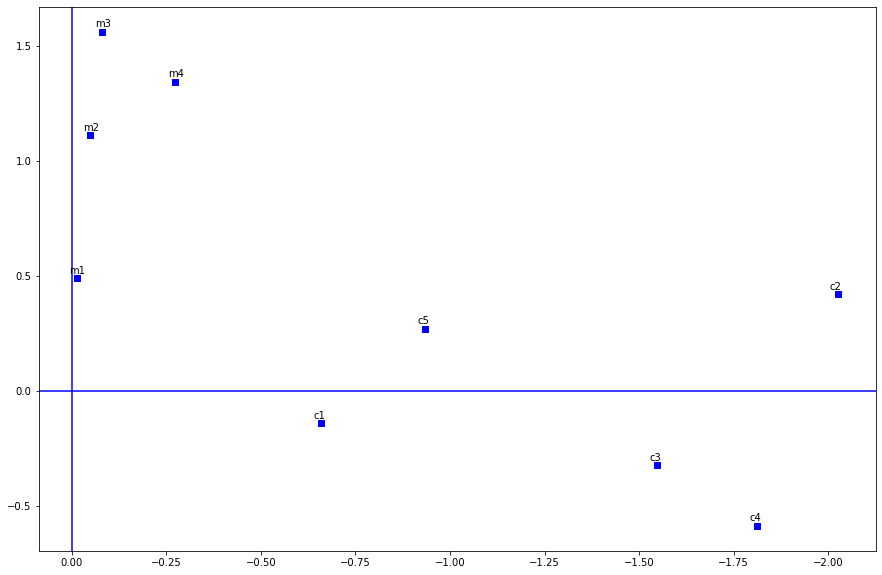

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.scatter(doc_plot[:,0],doc_plot[:,1], marker = 's', c = 'b')
plt.gca().invert_xaxis()

plt.axvline(0, color='gray', linestyle='-')
plt.axhline(0, color='gray', linestyle='-')

for i in range(doc_plot[:,0].shape[0]):
     plt.text(x=doc_plot[i,0]+0.02,y=doc_plot[i,1]+0.02,s=docName[i])
print(doc_plot)

##### Expected
```CPP
[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]
```
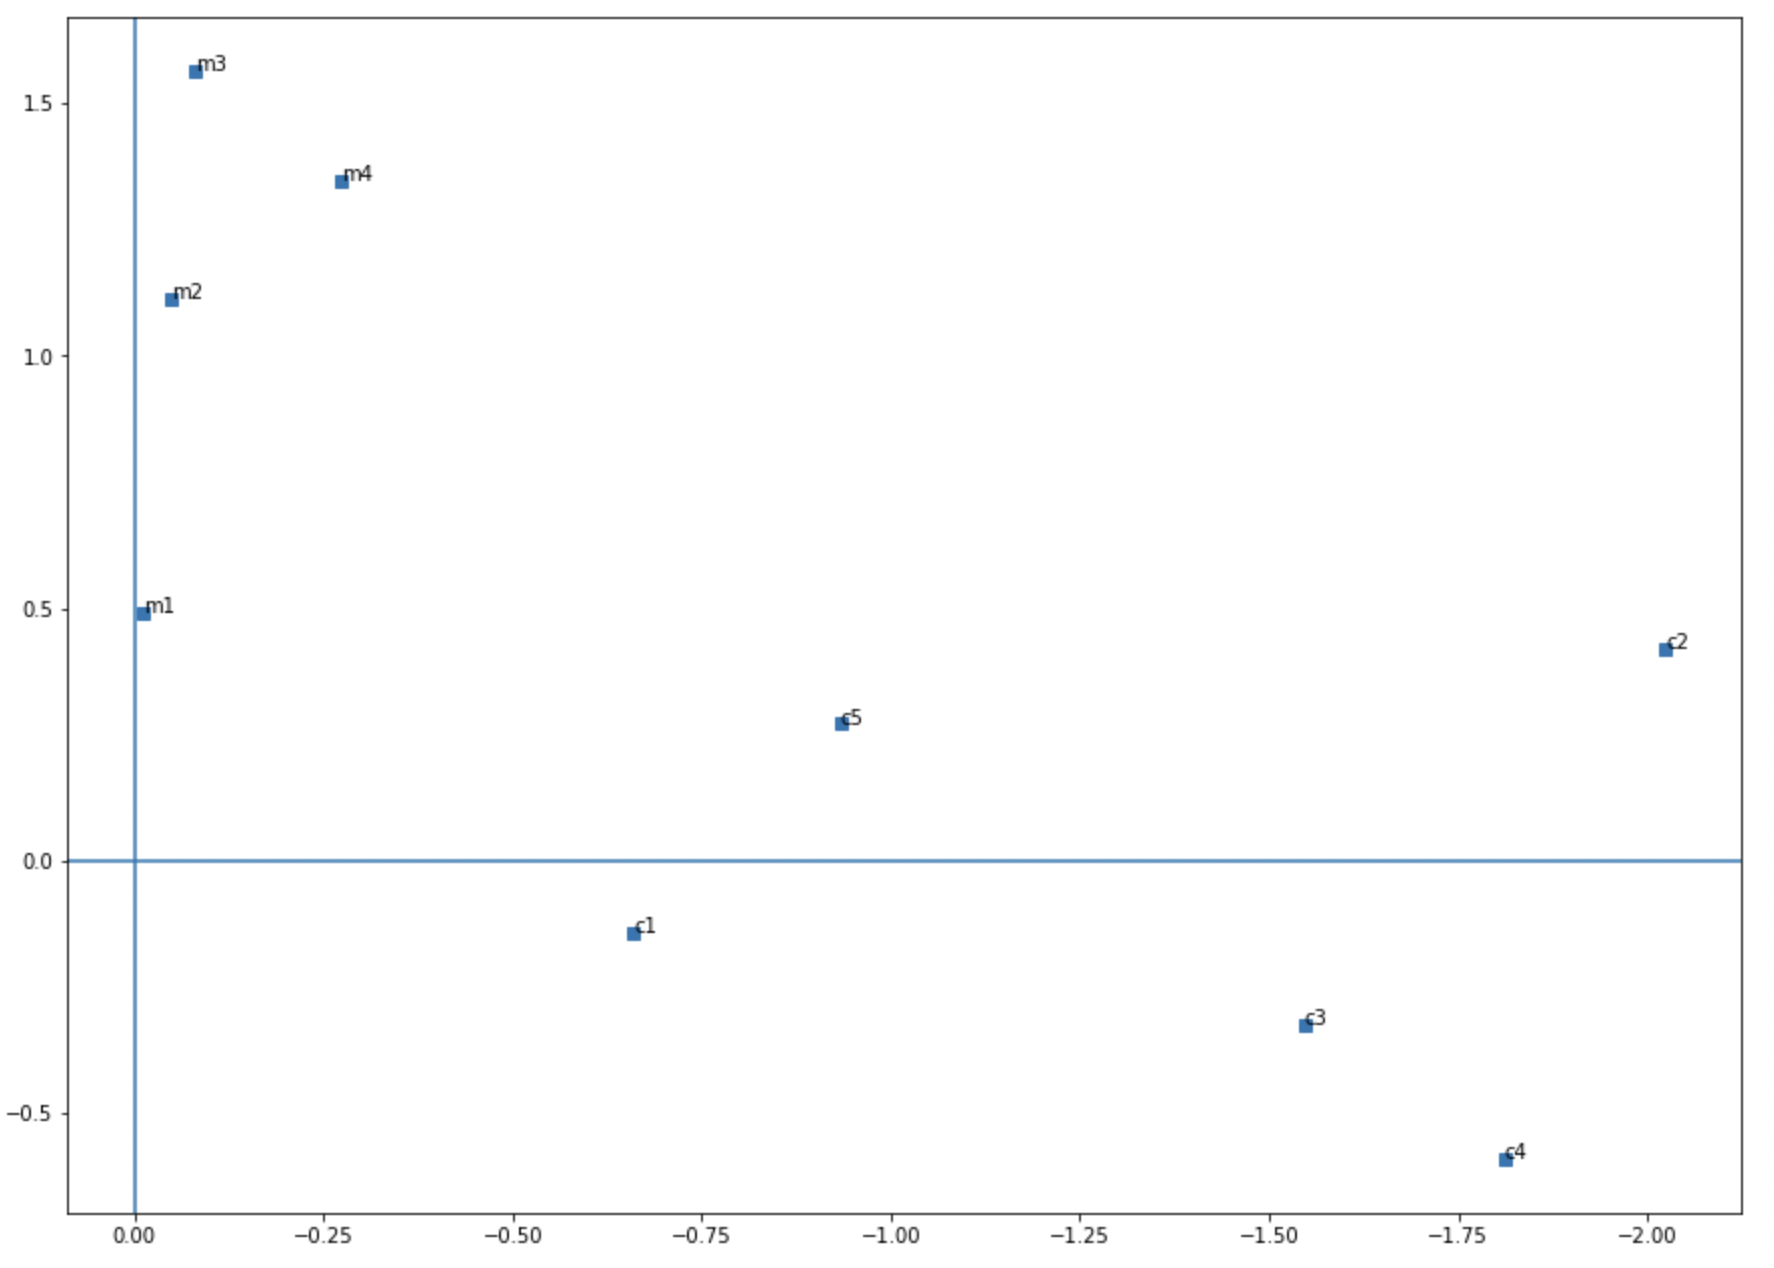

### Visualize terms in 2D space

In [76]:
term_plot = np.matmul(Uk, Sk)

In [77]:
termName = []
for key, value in word_to_ix.items():
    termName.append(str(value) + ' ' + key) 

In [78]:
print(term_plot)

[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-0.68794764  0.69552995]
 [-1.34837689  0.14505553]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]


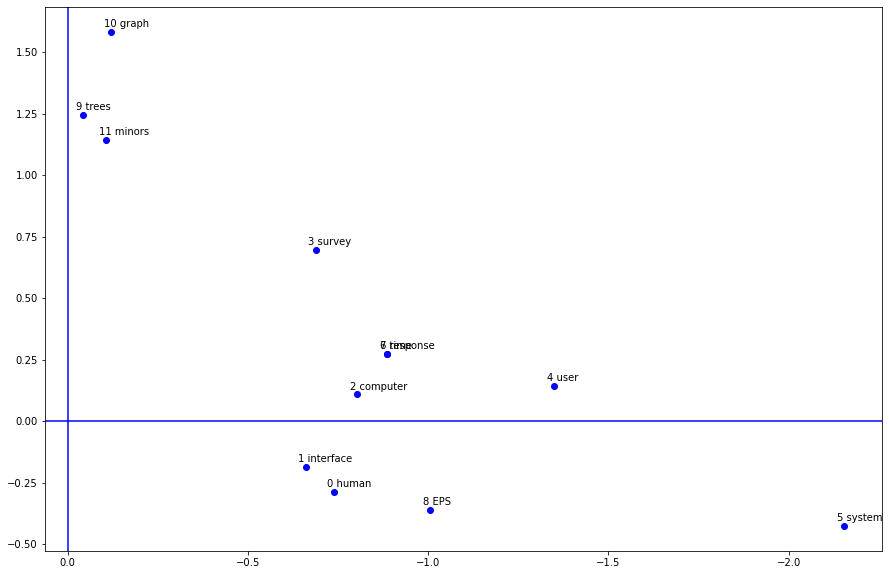

In [79]:
#Visualize terms and print coordinates
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.scatter(term_plot[:,0],term_plot[:,1], marker = 'o', c = 'b')

plt.axvline(0, color='gray', linestyle='-')
plt.axhline(0, color='gray', linestyle='-')

plt.gca().invert_xaxis()
for i in range(term_plot[:,0].shape[0]):
     plt.text(x=term_plot[i,0]+0.02,y=term_plot[i,1]+0.02,s=termName[i])

##### Expected
```CPP
[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-1.34837689  0.14505553]
 [-0.68794764  0.69552995]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]
```
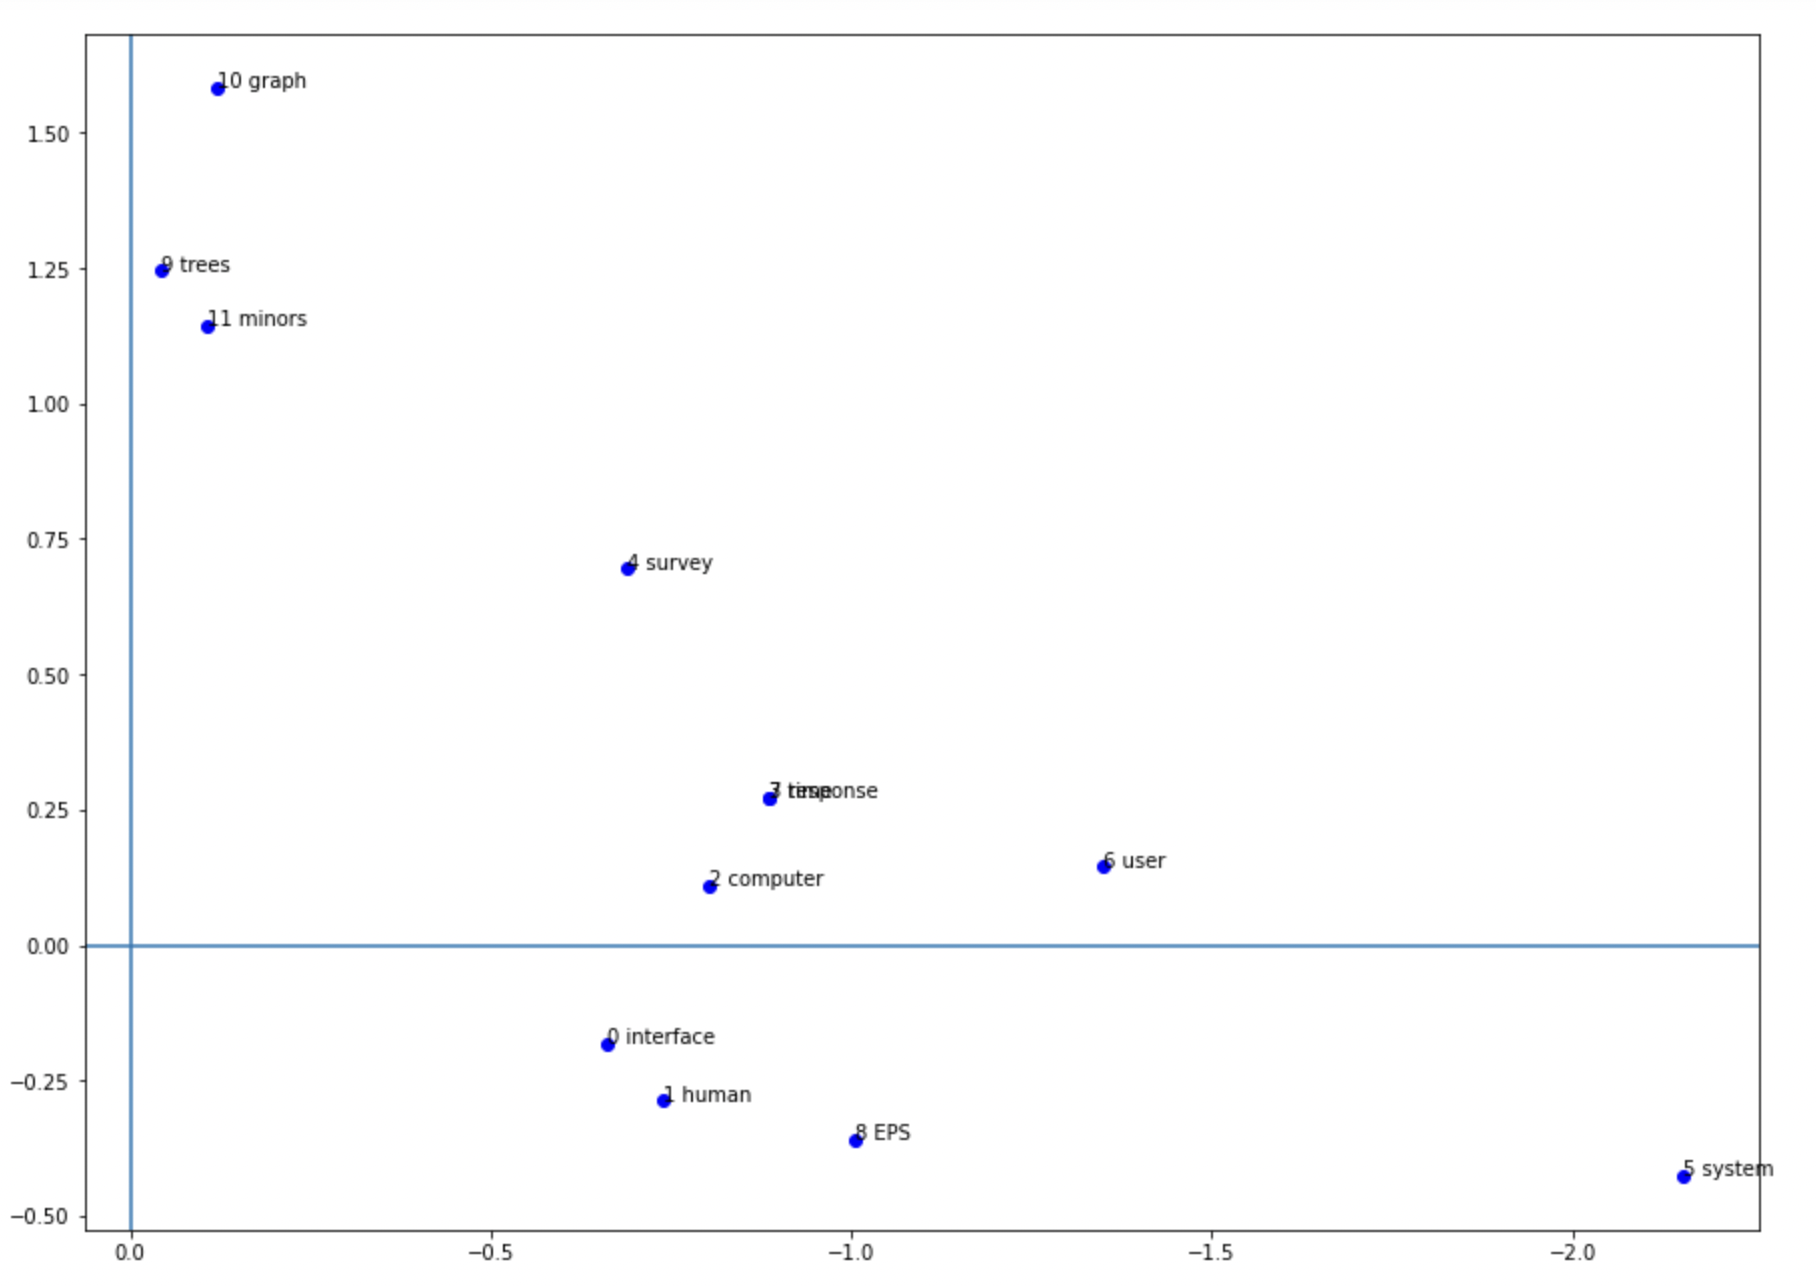

## <CENTER>Task-3 (10 Points)

### Find matching documents for given document

In [80]:
# Hint create query vector for input document. Calculate its cosine distance from other documents

def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
    '''
    Input:
        s:query document.
        Uk:Term matrix
        Sk:singular value matrix
        Vk_t:Document matrix
        word_to_ix: {word, index} map
        documents:list of document
        min_score:min score beyond which documents are considerd matching
    Output:
        q_hat: coordinates of query vector
        matches: list of tuples containing matching document and its score
    '''
    
    # fit in above term-document matrix
    token_docs = [preprocess(s)]
    X = build_td_matrix(token_docs, word_to_ix).T
    q_hat = np.dot(X, Uk)[0]
    n_q_hat = np.linalg.norm(q_hat)
    matches = []
    for q_index in range(len(doc_plot)):
        q = doc_plot[q_index]
        dot_product = np.dot(q_hat, q)
        n_q = np.linalg.norm(q)
        cos_angle = dot_product / ( n_q * n_q_hat )
        if cos_angle >= 0.9:
            matches.append((documents[q_index],cos_angle))
    return q_hat, matches

In [81]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[-0.461821   -0.07002767]
[('Human machine interface for Lab ABC computer applications', 0.9980930095689975), ('A survey of user opinion of computer system response time', 0.9374863669686594), ('The EPS user interface management system', 0.998445281334027), ('System and human system engineering testing of EPS', 0.9865886405556596), ('Relation of user-perceived response time to error measurement', 0.907559436264434)]


##### Expected
```CPP
[-0.461821   -0.07002767]
[('The EPS user interface management system', 0.9984452813340272), ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('System and human system engineering testing of EPS', 0.9865886405556598), ('A survey of user opinion of computer system response time', 0.9374863669686595), ('Relation of user-perceived response time to error measurement', 0.9075594362644345)]
```

### Visual representation of query/document

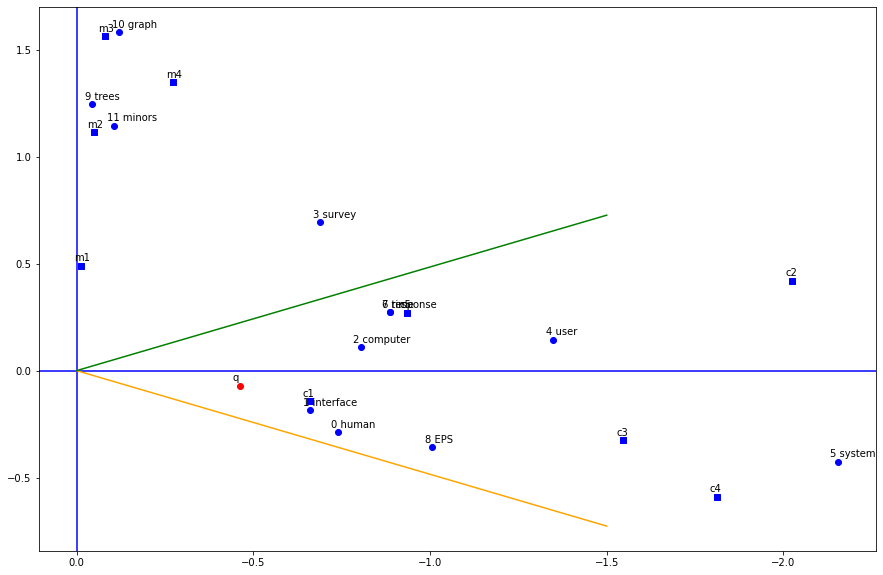

In [82]:
# Plot terms, documents and query documents along with lines representing its cosine angle 

fig = plt.figure(figsize=(15, 10))
plt.gca().invert_xaxis()

# plot terms
plt.scatter(term_plot[:,0],term_plot[:,1], marker = 'o', c = 'b')
for i in range(term_plot[:,0].shape[0]):
     plt.text(x=term_plot[i,0]+0.02,y=term_plot[i,1]+0.02,s=termName[i])

# plot docs
plt.scatter(doc_plot[:,0],doc_plot[:,1], marker = 's', c = 'b')
for i in range(doc_plot[:,0].shape[0]):
     plt.text(x=doc_plot[i,0]+0.02,y=doc_plot[i,1]+0.02,s=docName[i])
        
# plot q
plt.scatter(q_hat[0],q_hat[1], marker = 'o', c = 'r')
plt.text(x=q_hat[0]+0.02,y=q_hat[1]+0.02,s='q')

plt.axvline(0, color='gray', linestyle='-')
plt.axhline(0, color='gray', linestyle='-')

m = np.tan(np.arccos(0.9))
x = [0, -1.5]
y = [0, m * -1.5]
plt.plot(x,y, c='orange')

m = np.tan(np.arccos(-0.9))
x = [0, -1.5]
y = [0, m * -1.5]
plt.plot(x,y, c='green')


##### Expected

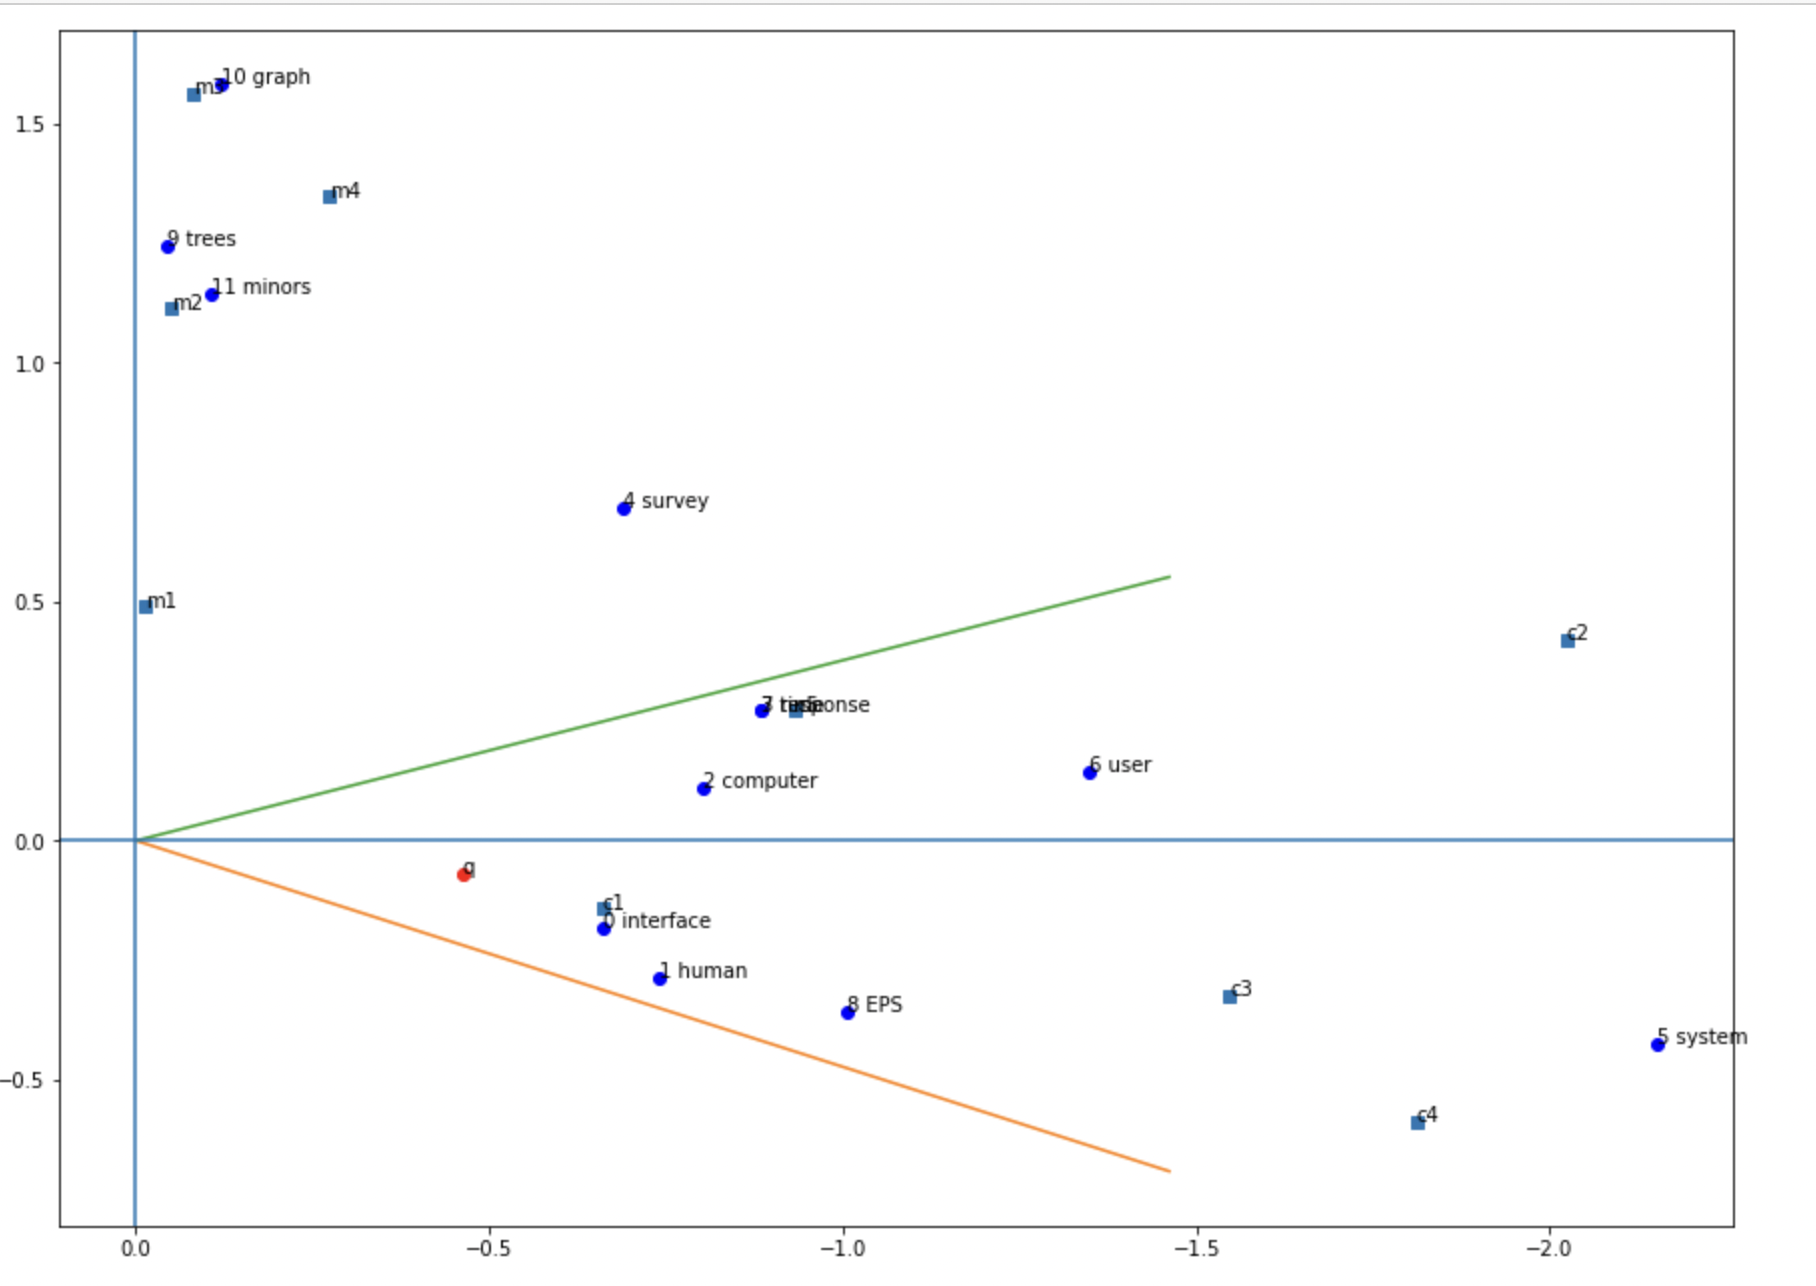


## **Theory questions: (5 points)**
- A) Give short description of Left-eigen vectors, right-eigen vectors and eigen-values matrix retured by Singular Value Decompostion of document-terms count matrix.
- B) Visually represent the document "Graph and tree generation" in 2D space along with words and documents as given in previous question.

## Answer A: 
The left eigen vectors consists of properties of each term with every other term.
Whereas the right eigen vector contains the relation between documents for every document with one another.

Eigen values are the scalar values that are used to get the relation between words and document.

# Q2. n-Gram Language Models

Your task is to train n-gram language models. [Ref SLP Chapter 3]

- Task 1: You will train unigram, bigram, and trigram models on given training files. Then you will score on given test files for unigram, bigram, and trigram. you will generate sentences from the trained model and compute perplexity.
- Task 2: You will create training data for n > 3. and Repeat the above task from training model.
<h6>Part-A = (55 Points) </h6>

In [117]:
'''
Your imports go here
You are encouraged to implement your own functions and not use from library.
'''
import sys
from collections import Counter
import numpy as np

In [118]:
# constants to define pseudo-word tokens
# access via UNK, for instance
# for this assignemnt we will follow <s> tag for beginning of sentence and
# </s> for end of senetence as suggested in SLP Book. Check sample training files for reference.
UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

We need to initialise global variables for model

In [236]:

"""Initializes Parameters:
  n_gram (int): the n-gram order.
  is_laplace_smoothing (bool): whether or not to use Laplace smoothing
  threshold: words with frequency  below threshold will be converted to token
"""
# Initializing different object attributes
n_gram = 2
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = {}
threshold = 1

max_words = 15
min_words = 2


### Implement training function (10 points)

In [120]:
def make_ngrams(tokens: list, n: int) -> list:
    """Creates n-grams for the given token sequence.
    Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    n_grams = []
    for i in range(len(tokens)-n+1):
        n_grams.append(tuple(tokens[i:i+n]))
    return n_grams

In [121]:
def train(training_file_path):
    """Trains the language model on the given data. Input file that
    has tokens that are white-space separated, has one sentence per line, and
    that the sentences begin with <s> and end with </s>
    Parameters:
      training_file_path (str): the location of the training data to read

    Returns:
    N Gram Counts, Vocab, N Minus 1 Gram Counts
    """
    vocab_d = {}
    global n_gram
    global vocab 
    global n_gram_counts
    global n_minus_1_gram_counts
    with open(training_file_path, 'r') as fh:
        content = fh.read().split() # Read and split data to get list of words
        
        # Get the count of each word
        train_sentence = []
        for word in content:
            if word in vocab_d:
                vocab_d[word] += 1
            else:
                vocab_d[word] = 1
        
        # Replace the words with <UNK> if count is < threshold(=1)
        for i in range(len(content)):
            if vocab_d[content[i]] <= threshold:
                content[i] = UNK
                
        
        # make use of make_n_grams function
        n_grams = make_ngrams(content, n_gram)
        
        # Get the training data vocabulary
        vocab = vocab_d.keys()
        count_vocab = len(content)
        
        # For n>1 grams compute n-1 gram counts to compute probability
        for gram in n_grams:
            if gram in n_gram_counts:
                n_gram_counts[gram] += 1
            else:
                n_gram_counts[gram] = 1
                
        if n_gram > 1:
            n_minus_1_grams = make_ngrams(content, n_gram-1)

            for gram in n_minus_1_grams:
                if gram in n_minus_1_gram_counts:
                    n_minus_1_gram_counts[gram] += 1
                else:
                    n_minus_1_gram_counts[gram] = 1
        else:
            n_minus_1_gram_counts = {}
            for w in vocab:
                n_minus_1_gram_counts[w] = count_vocab
            
    return n_gram_counts, vocab, vocab_d, n_minus_1_gram_counts, count_vocab

Output your Trained Data Parameters:

In [122]:
is_laplace_smoothing = True
threshold = 1

n_gram = 1
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = {}
uni_gram_counts, uni_vocab, uni_vocab_dict, uni_minus_1_gram_counts, uni_total_vocab = train("data/train_data/berp-training_uni.txt")

n_gram = 2
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = {}
bi_gram_counts, bi_vocab, bi_vocab_dict, bi_minus_1_gram_counts, bi_total_vocab = train("data/train_data/berp-training_bi.txt")

n_gram = 3
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = {}
tri_gram_counts, tri_vocab, tri_vocab_dict, tri_minus_1_gram_counts, tri_total_vocab = train("data/train_data/berp-training-tri.txt")


In [123]:
gram_count_dict = {1:uni_gram_counts, 2:bi_gram_counts, 3:tri_gram_counts}
gram_minus_count_dict = {1:uni_minus_1_gram_counts, 2:bi_minus_1_gram_counts, 3:tri_minus_1_gram_counts}
vocab_dict = {1:uni_vocab, 2:bi_vocab, 3:tri_vocab}
vocab_count_dict = {1:uni_vocab_dict, 2:bi_vocab_dict, 3:tri_vocab_dict}
vocab_total_count_dict = {1:uni_total_vocab, 2:bi_total_vocab, 3:tri_total_vocab}

In [ ]:
# n_gram_counts, vocab, n_minus_1_gram_counts = train("data/train_data/berp-training_bi.txt")
# print(n_gram_counts)
# print(vocab)

{('<s>', '<s>', '<s>', "let's"): 196, ('<s>', '<s>', "let's", 'start'): 163, ('<s>', "let's", 'start', 'over'): 131, ("let's", 'start', 'over', '</s>'): 124, ('start', 'over', '</s>', '</s>'): 366, ('over', '</s>', '</s>', '</s>'): 367, ('</s>', '</s>', '</s>', '<s>'): 6755, ('</s>', '</s>', '<s>', '<s>'): 6755, ('</s>', '<s>', '<s>', '<s>'): 6755, ('<s>', '<s>', '<s>', 'my'): 6, ('<s>', '<s>', 'my', 'mother'): 1, ('<s>', 'my', 'mother', 'is'): 1, ('my', 'mother', 'is', 'coming'): 1, ('mother', 'is', 'coming', 'to'): 1, ('is', 'coming', 'to', 'visit'): 1, ('coming', 'to', 'visit', 'and'): 1, ('to', 'visit', 'and', "i'd"): 1, ('visit', 'and', "i'd", 'like'): 1, ('and', "i'd", 'like', 'to'): 4, ("i'd", 'like', 'to', 'take'): 4, ('like', 'to', 'take', '<UNK>'): 1, ('to', 'take', '<UNK>', 'to'): 1, ('take', '<UNK>', 'to', 'dinner'): 1, ('<UNK>', 'to', 'dinner', '</s>'): 1, ('to', 'dinner', '</s>', '</s>'): 7, ('dinner', '</s>', '</s>', '</s>'): 224, ('<s>', '<s>', '<s>', 'new'): 1, ('<s>',

### Scoring function (points 5):
Implement Score function that will take input sentence and output probability of given string representing a single sentence.

In [202]:
def score(sentence):
    """Calculates the probability score for a given string representing a single sentence.
    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    global n_gram
    global gram_count_dict
    global gram_minus_count_dict
    global vocab_dict
    global vocab_count_dict
    global vocab_total_count_dict
    
    # Split the input sentence and replace out of vocabulary tokens with <UNK>
    s_tokens = sentence.split()
    vocabs = vocab_dict[n_gram]
    unique_vocab_count = len(vocabs) - 1
    s_gram_counts = gram_count_dict[n_gram]
    s_gram_minus_1_counts = gram_minus_count_dict[n_gram]

    for i in range(len(s_tokens)):
        if s_tokens[i] not in vocabs:
            s_tokens[i] = UNK
            
    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    probablity = 1

    s_n_grams = make_ngrams(s_tokens, n_gram)
    for s_n_gram in s_n_grams:
        s_n_minus_1_gram = s_n_gram[0:n_gram-1]
        x = 0
        y = 0
        if s_n_minus_1_gram in s_gram_minus_1_counts:
            x = s_gram_minus_1_counts[s_n_minus_1_gram]
        if s_n_gram in s_gram_counts:
            y = s_gram_counts[s_n_gram]
        probablity *= ( (y + 1) / (x + unique_vocab_count) )

    if probablity > 1:
        print(sentence)
        print(s_n_grams)
        print(probablity)
        print("=========")
    
    return probablity

In [203]:
global n_gram
n_gram = 3
with open("data/test_data/hw2-test-tri.txt", 'r') as fh:
    test_content = fh.read().split("\n")
num_sentences_1 = len(test_content)
ten_sentences_1 = test_content[:10]
print("# of test sentences: ", num_sentences_1)


# of test sentences:  102


In [204]:
# print probabilities/score of sentences in test content
probablities = []
for sentence in test_content:
    probablities.append(score(sentence))
probablities = np.array(probablities)
print("Probabilities: ", probablities)
mean = np.mean(probablities)
print("Mean of Probabilities: ", mean)
std_dev = np.std(probablities)
print("Standard Deviation: ", std_dev)

Probabilities:  [7.81394514e-13 4.14121812e-11 4.87003527e-22 4.14973187e-18
 1.13381638e-25 8.20312394e-17 3.25189782e-17 6.01094545e-31
 1.70850334e-22 6.26528174e-11 8.02094581e-13 1.21757552e-14
 1.52388718e-17 9.32455835e-08 2.31212712e-16 2.85241493e-08
 5.33378831e-08 7.68723350e-09 1.76931713e-17 7.22261118e-26
 1.96983567e-44 3.50994802e-40 2.82340730e-26 1.58991237e-24
 2.29675686e-21 2.39355283e-14 1.68702121e-08 1.90035747e-13
 3.23778155e-27 1.94449640e-17 6.50526583e-13 1.44193513e-22
 5.04476819e-18 9.14350935e-16 1.05415191e-23 1.13714030e-21
 7.75357825e-11 4.16593282e-11 6.48280575e-18 5.64751583e-14
 5.27077435e-18 2.47722423e-16 2.31016912e-15 3.02413566e-22
 1.59594862e-20 8.61514558e-20 2.71744267e-14 2.10626712e-14
 1.62123968e-22 1.40611058e-25 3.36182352e-28 2.06363504e-19
 7.82543163e-08 9.20431434e-06 9.20431434e-06 1.15116974e-17
 4.71820585e-17 2.73520374e-09 2.23245520e-10 2.96732597e-20
 1.80183512e-04 1.23881603e-18 6.03807575e-23 4.29557349e-15
 1.47501

### Sentence generation (10 points)
Generate sentence from the above trained model
- To generate next word from a set of probable n-grams and their probabilities check below tutorial:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [205]:
# uni gram probability
uni_vocabs = vocab_count_dict[1]
uni_count = vocab_total_count_dict[1]
uni_words_x = []
uni_probabilities_x = []
for key, value in uni_vocabs.items():
    uni_words_x.append(key)
    uni_probabilities_x.append(value/uni_count)

In [245]:
def generate_sentence():
    """Generates a single sentence from a trained language model using the Shannon technique.
      
    Returns:
      str: the generated sentence
    """
    # Start with <s> and randomly generate words until we encounter sentence end
    # Append sentence begin markers for n>2
    # Keep track of previous word for stop condition
    global n_gram
    vocabs = vocab_dict[n_gram]
    sentence = []
    prev_word = ""
    length_c = 0
    if n_gram > 1:
        for _ in range(n_gram-1):
            sentence.append(SENT_BEGIN)
        
        while prev_word != "</s>" or length_c < min_words:
            # Construct the (n-1) gram so far
            c_minus_1_sentence = " ".join(sentence[-(n_gram-1):])
            n_words = []
            n_word_probability = []
            for w in vocabs:
                n_words.append(w)
                n_word_probability.append(score(" ".join(sentence) + " " + w))
            
            n_word_probability = np.array(n_word_probability)
            sum_prob = sum(n_word_probability)
            if sum_prob == 0:
                word = np.random.choice(n_words, 1)[0]
            else:
                n_word_probability /= sum_prob
                word = np.random.choice(n_words, 1, p=n_word_probability)[0]
                
            if word != SENT_BEGIN:
                if length_c < min_words and word == SENT_END:
                    continue
                elif length_c == max_words:
                    sentence.append(SENT_END)
                    prev_word = SENT_END
                else:
                    sentence.append(word)
                    length_c += 1
                    prev_word = word
            
        # Get the counts of all available choices based on n-1 gram
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
    else:
        sentence.append(SENT_BEGIN)
        # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
        while prev_word != "</s>" or length_c < min_words:
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
            word = np.random.choice(uni_words, 1, p=uni_probabilities)[0]

            if word != SENT_BEGIN:
                if length_c < min_words and word == SENT_END:
                    continue
                elif length_c == max_words:
                    sentence.append(SENT_END)
                    prev_word = SENT_END
                else:
                    sentence.append(word)
                    length_c += 1
                    prev_word = word
                    
    # Append sentence end markers for n>2
    if n_gram > 2:
        for _ in range(n_gram-2):
            sentence.append(SENT_END)
    return " ".join(sentence)

In [246]:
def generate(n):
    """Generates n sentences from a trained language model using the Shannon technique.
    Parameters:
      n (int): the number of sentences to generate
      
    Returns:
      list: a list containing strings, one per generated sentence
    """
    # Generate sentences one by one and store
    sentences = []
    for i in range(n):
        sentences.append(generate_sentence())
    return sentences

In [247]:
n_gram = 1
sentences = generate(50)
print("Sentences:")
for sentence in sentences:
    print(sentence)

Sentences:
<s> be type taqueria and to cheap than </s>
<s> like restaurant spend amount can start i tour lunch like </s>
<s> restaurant ten homemade to i thirty five over </s>
<s> i are matter to </s>
<s> a from lilly's vietnamese cost </s>
<s> serve me i on um of i don't to </s>
<s> minutes minutes more it the distance me on everett want </s>
<s> i to want please any about i'd chinese for tell </s>
<s> food the dollars these rick food close let's </s>
<s> sushi italian about icksee please to restaurants go like about </s>
<s> are have go please minutes i to i a query </s>
<s> cuisine want start bart weekends would sunday restaurant can forty </s>
<s> i about let's eiffel menu information thank let's back don't </s>
<s> don't serve information one uh between recommend a </s>
<s> cafe icsi um a would spending </s>
<s> want want meat you indian to um </s>
<s> of instead fifteen real looking this want can like next </s>
<s> the wanna saturday hamburger would about today i two restaurant <

### Evaluate model perplexity (5 points)
Measures the perplexity for the test sequence with your trained model. 
you may assume that this sequence may consist of many sentences "glued together"

The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words.


In [254]:
# Since this sequence will cross many sentence boundaries, we need to include 
# the begin- and end-sentence markers <s> and </s> in the probability computation. 
# We also need to include the end-of-sentence marker </s> 
# but not the beginning-of-sentence marker <s>) in the total count of word tokens N

def perplexity(test_sequence):
    """.
    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of

    Returns:
      float: the perplexity of the given sequence
    """ 

    # Replace out of vocab words with <UNK>, already done in score function
    test_sequence = [token if token in vocab else UNK for token in test_sequence.split()]
    
    # Remove sentence begin markers from data for computing N
    n_seq = [token for token in test_sequence if token != SENT_BEGIN ]
    
    # Get the probability for the sequence
    p = score(" ".join(test_sequence))
    
    perplexity = (1 / p) ** (1 / len(n_seq) - n_gram + 1)
    return perplexity

In [255]:
print(perplexity(" ".join(sentences[0:10])))

2.9206680584551177


### **Explore and explain: (5 points)**
* Experiment n_gram model for n = [1,2,3..7] of your choice. Explain the best choice of n that generates more meaninful sentences.


# Q3. Classification using LSTM - using Tensorflow (30 Points)
In this part, we will be building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.<br>

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time to tweak your hyperparameters.
- Without a GPU, You might have to wait longer to experiment.

### Library Imports

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



### Visualizing data distribution (1 Point)


In [5]:
## Reading the data and removing columns that are not important. 
dataset = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [6]:
 #######################################################   
 # print head of data frame with help of head function # 
 #######################################################
dataset.head()


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Petter Mattei's "Love in the Time of Money" is...  positive
4  Probably my all-time favorite movie, a story o...  positive

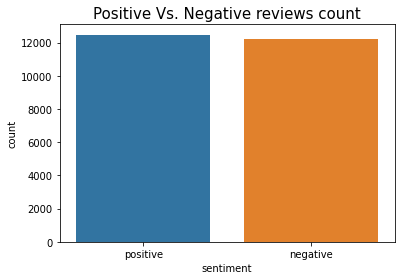

In [8]:
 ####################################################### 
 # plot Positive Vs. Negative reviews count            # 
 #######################################################

sns.countplot(x="sentiment", data=dataset)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()



### Cleaning the Reviews (2 Points)

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /Users/shadow/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shadow/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/shadow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/shadow/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [17]:
 #############################################################################################  
 # Clean all the reviews in the dataset using the clean_text function provided above         # 
 ############################################################################################# 
for i in range(dataset.shape[0]):
    dataset.iloc[i,0] = clean_text(dataset.iloc[i,0])


In [18]:
 #####################################################################
 # print head of the "CLEANED" data frame with help of head function # 
 #####################################################################
dataset.head()


review sentiment
0  one reviewer mentioned watching 1 oz episode y...  positive
1  wonderful little production br br filming tech...  positive
2  thought wonderful way spend time hot summer we...  positive
3  petter matteis love time money visually stunni...  positive
4  probably alltime favorite movie story selfless...  positive

### Splitting the dataset and Encoding Labels (2 Points)

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [43]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################
x_train, x_test, y_train, y_test = train_test_split(dataset["review"], dataset["sentiment"],test_size=0.20, random_state=42)

x_train = x_train.to_frame()
x_test = x_test.to_frame()

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


x_train: (19759, 1)
x_test: (4940, 1)
y_train: (19759,)
y_test: (4940,)


In [65]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################
l_train_encoder = LabelEncoder()
y_encoder = l_train_encoder.fit(y_train)

### Pre-Processing The Text (5 Points)
 

In [45]:
# You can use the modules given below
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.text import Tokenizer

###############################################################################  
# Fit your tokenizer on the training reviews                                  #
###############################################################################
keras_tokenizer  = Tokenizer()
keras_tokenizer.fit_on_texts(x_train['review'])


#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                  #
#################################################################################################

word_index = keras_tokenizer.word_index
vocabulary = keras_tokenizer.word_counts


#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
# HINT : convert training and validation reviews into sequences                                 #
#################################################################################################
train_sequences = keras_tokenizer.texts_to_sequences(x_train['review'])
test_sequences = keras_tokenizer.texts_to_sequences(x_test['review'])


#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
# set maxlen = 200                                                                              #
#################################################################################################

# maxlen which is the maximum length of one review we will use for our training
padded_train_sequences = pad_sequences(train_sequences, maxlen=200)
padded_test_sequences = pad_sequences(test_sequences, maxlen=200)

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : OrderedDict([('kid', 2301), ('loved', 1110), ('computer', 414), ('animation', 588), ('although', 1921), ('extremely', 884), ('limited', 221), ('tool', 57), ('almost', 2437), ('nonexistent', 123), ('movie', 39235), ('sat', 224), ('awe', 64), ('watched', 1749), ('amazing', 1018), ('image', 703), ('almosthypnotic', 1), ('music', 2416), ('shaped', 30), ('desire', 264), ('create', 471), ('moving', 643), ('thing', 6270), ('wholepackage', 1), ('deal', 842), ('video', 1243), ('really', 8805), ('pack', 134), ('onetwo', 3), ('punch', 164), ('know', 5497), ('child', 1916), ('want', 3775), ('get', 9782), ('involved', 847), ('must', 2538), ('br', 45308), ('still', 4315), ('20', 539), ('year', 4855), ('later', 1668), ('rate', 501), ('one', 21148), ('top', 1254), ('3', 1142), ('favorite', 1103), ('originality', 151), ('think', 5931), ('unsurpassed', 15), ('today', 997), ('mcmovies', 1), ('hollywood', 1394), ('spit', 50), ('currently', 102), ('wanting', 231), ('see', 9261), ('remake', 508

### Using glove vectors for embedding (5 Points)

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.

To learn more about GloVe please read the following resource:
- https://nlp.stanford.edu/pubs/glove.pdf

In [46]:
glove_dictionary = {}
with open('glove.6B.200d.txt') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [49]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((len(vocabulary), 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################
for word, index in word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index, :] = embedding_vector


In [50]:
embedding_matrix.shape

(99734, 200)

Sample output : (99987, 200)

### Creating The Model (10)

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time.
- Without a GPU, You might have to wait longer to experiment.


Useful resources : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout <br>





In [59]:
import tensorflow as tf
import tensorflow.keras.metrics as metrics
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Input, Embedding

tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):

    ''' 
  Arguments:
    embedding_matrix : a matrix with the corresponding embeddings
    of all words.

  Returns:
    The LSTM model that you created.
    '''
  
    model = tf.keras.Sequential()

  # TO DO: layer 1 : add embedding layer
  # The embedding layer maps the words to their embedding vectors from the embedding matrix
    model.add(Embedding(len(vocabulary), 200, input_length=200, weights = [embedding_matrix], trainable=False))

  # TO DO: layer 2 : add Bidirectional LSTM Layer 
    model.add(Bidirectional(LSTM(128)))


  # TO DO Add more layers : you can add more dense layers and dropout
  # NOTE : You should be able to achieve an validation accuracy greater than 85%
  #        within 10 epochs
    model.add(Dense(64))
    model.add(Dropout(0.5))

    model.add(Dense(32))
    model.add(Dropout(0.5))
              
    model.add(Dense(16))
    model.add(Dropout(0.5))
              
  # TO DO Final layer : add output layer and activation 
    model.add(Dense(1, activation='sigmoid'))


  # TO DO : use a loss function, optimizer as adam to compile 
  # and evaluate model on auc,precision,recall,accuracy
  # HINT : choose your loss function based on the task (binary classification)
    adam = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', metrics.Precision(), metrics.Recall(), metrics.AUC()])
  
    return model

In [67]:
# NOTE : You should be able to achieve an validation accuracy greater than 85%
#        within 10 epochs

#################################################################
# Call the build_model function and initialize the model        #
#################################################################
lstm_model = build_model(embedding_matrix)

#######################################################################################################
# train and validate the model on the padded sequences of text which we have created initially        #
#######################################################################################################
evaluate = lstm_model.fit(padded_train_sequences, y_encoder.transform(y_train), validation_data=(padded_test_sequences, y_encoder.transform(y_test)), batch_size=64, epochs=10)


Epoch 1/10
309/309 [==============================] - 47s 137ms/step - loss: 0.5305 - acc: 0.7368 - precision_5: 0.7396 - recall_5: 0.7410 - auc_5: 0.8138 - val_loss: 0.4034 - val_acc: 0.8194 - val_precision_5: 0.7910 - val_recall_5: 0.8685 - val_auc_5: 0.9048
Epoch 2/10
309/309 [==============================] - 40s 129ms/step - loss: 0.4061 - acc: 0.8232 - precision_5: 0.8254 - recall_5: 0.8254 - auc_5: 0.8970 - val_loss: 0.3917 - val_acc: 0.8377 - val_precision_5: 0.7990 - val_recall_5: 0.9025 - val_auc_5: 0.9199
Epoch 3/10
309/309 [==============================] - 41s 134ms/step - loss: 0.3498 - acc: 0.8496 - precision_5: 0.8505 - recall_5: 0.8528 - auc_5: 0.9246 - val_loss: 0.3408 - val_acc: 0.8561 - val_precision_5: 0.8607 - val_recall_5: 0.8499 - val_auc_5: 0.9327
Epoch 4/10
309/309 [==============================] - 39s 127ms/step - loss: 0.3075 - acc: 0.8699 - precision_5: 0.8720 - recall_5: 0.8707 - auc_5: 0.9421 - val_loss: 0.3078 - val_acc: 0.8702 - val_precision_5: 0.8563

### Plotting Accuracy and Losses (5 Points)
 




In [88]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################
train_loss = evaluate.history['loss']
train_acc = evaluate.history['acc']
train_precision = evaluate.history['precision_5']
train_recall = evaluate.history['recall_5']
train_auc = evaluate.history['auc_5']

val_loss = evaluate.history['val_loss']
val_acc = evaluate.history['val_acc']
val_precision = evaluate.history['val_precision_5']
val_recall = evaluate.history['val_recall_5']
val_auc = evaluate.history['val_auc_5']

epoches = [i for i in range(1,11)]




[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

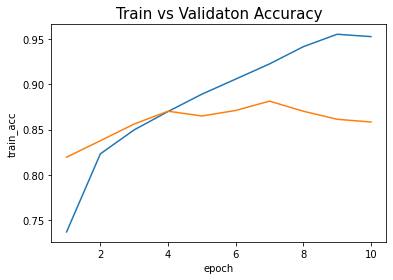

In [108]:
columns = ['epoch', 'train_acc', 'val_acc']
a_data = pd.DataFrame(np.column_stack([epoches, train_acc, val_acc]), columns=columns)
sns.lineplot(data=a_data, x="epoch", y="train_acc")
sns.lineplot(data=a_data, x="epoch", y="val_acc")
plt.title("Train vs Validaton Accuracy", fontsize = 15)
plt.show()

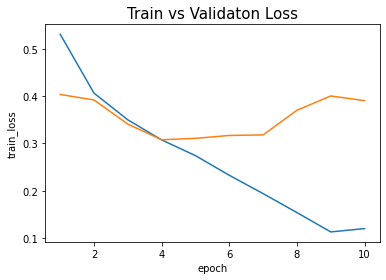

In [109]:
columns = ['epoch', 'train_loss', 'val_loss']
l_data = pd.DataFrame(np.column_stack([epoches, train_loss, val_loss]), columns=columns)
sns.lineplot(data=l_data, x="epoch", y="train_loss")
sns.lineplot(data=l_data, x="epoch", y="val_loss")
plt.title("Train vs Validaton Loss", fontsize = 15)
plt.show()

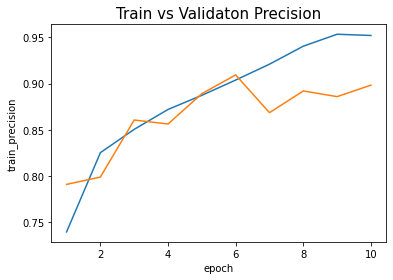

In [110]:
columns = ['epoch', 'train_precision', 'val_precision']
p_data = pd.DataFrame(np.column_stack([epoches, train_precision, val_precision]), columns=columns)
sns.lineplot(data=p_data, x="epoch", y="train_precision")
sns.lineplot(data=p_data, x="epoch", y="val_precision")
plt.title("Train vs Validaton Precision", fontsize = 15)
plt.show()

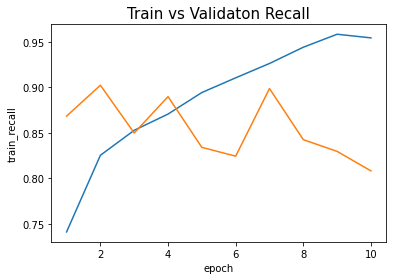

In [111]:
columns = ['epoch', 'train_recall', 'val_recall']
r_data = pd.DataFrame(np.column_stack([epoches, train_recall, val_recall]), columns=columns)
sns.lineplot(data=r_data, x="epoch", y="train_recall")
sns.lineplot(data=r_data, x="epoch", y="val_recall")
plt.title("Train vs Validaton Recall", fontsize = 15)
plt.show()

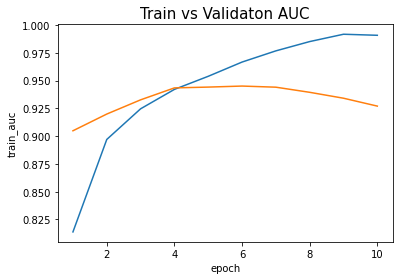

In [112]:
columns = ['epoch', 'train_auc', 'val_auc']
auc_data = pd.DataFrame(np.column_stack([epoches, train_auc, val_auc]), columns=columns)
sns.lineplot(data=auc_data, x="epoch", y="train_auc")
sns.lineplot(data=auc_data, x="epoch", y="val_auc")
plt.title("Train vs Validaton AUC", fontsize = 15)
plt.show()

In [76]:
# You will need to include the pickled model along with the other submission files
# The saved model will be used to verify your lstm's predictions on hidden reviews

##################################################################################
# Save your trained model as a pickle file named "lstm_classifier"               #
# You will be using this saved model to make predictions in the next module      #
##################################################################################

import pickle 
with open('lstm_classifier', 'wb') as files:
    pickle.dump(lstm_model, files)

INFO:tensorflow:Assets written to: ram://743888c0-e13e-41ef-a513-a9e2536a156a/assets


INFO:tensorflow:Assets written to: ram://743888c0-e13e-41ef-a513-a9e2536a156a/assets


### Prediction (5 Points)

In [77]:
######################################################################
# Load your saved model                                              #
# Use the saved model to make predictions                            #
######################################################################
with open('lstm_classifier' , 'rb') as f:
    saved_model = pickle.load(f)


In [78]:
# use the saved model to predict the reviews
def predict_review(review):
    '''
  Arguments:
    review : A single review for which you want to predict the sentiment for.
             example: "This movie was amazing! I would defenitely watch it again."

  Returns:
    The predicted sentiment for the review : either 1 or 0
    '''

 ############################################################################# 
 # Predict the sentiment for the given review using the model                #
 # that you trained and return the sentiment                                 #
 #                                                                           #
 # HINT : Remember that the review needs to be "preprocessed" before you use #
 # it for prediction                                                         #
 #############################################################################
    review = clean_text(review)
    review_seq = keras_tokenizer.texts_to_sequences([review])
    review_seq = pad_sequences(review_seq, maxlen=200)
    p = saved_model.predict(review_seq)[0]
    if p > 0.5:
        return 1
    else: 
        return 0
    



In [79]:
# Do not edit this cell

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:100]} -> {p}')
    

1/1 [==============================] - 1s 1s/step
If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1
1/1 [==============================] - 0s 73ms/step
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0
1/1 [==============================] - 0s 73ms/step
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1
1/1 [==============================] - 0s 72ms/step
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0


### Expected Output:

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0 <br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0